# Simulation Study — Bias in Cross-Validation Estimates for Classification

Cross-validation (CV) is a standard technique to estimate the performance of classifiers, but it can exhibit bias, particularly with small datasets or in the presence of model selection. In this simulation study, you will quantify the bias of CV accuracy estimates by comparing them to the true generalization accuracy on a large, independent test set.



## PROBLEM 1: Bias of CV
We will visualize the bias of cross-validation as a function of the number of folds and data sample size

In [6]:
# set up your environment as necessary
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.datasets import make_classification
from tqdm import tqdm 

We will run a simulation in which we run many cross validation experiments and empirically measure the difference between the cross-validated performance estimate versus the actual performance. 

In each experiment, we will need to generate data using the code below. 

In [7]:
# Settings: DO NOT EDIT
TEST_SAMPLES = 5000 
N_FEATURES = 10

def generate_data(n_train):
    X, y = make_classification(n_samples=n_train+TEST_SAMPLES
                                , n_features=N_FEATURES
                                # affecting distribution of data: selected for this simulation
                                , n_informative=8 
                                , n_redundant=2 
                                , flip_y=0.2 
                                , class_sep=1.0)
    X_train, y_train = X[:n_train], y[:n_train]
    X_test, y_test = X[n_train:], y[n_train:]
    return X_train, y_train, X_test, y_test
                
# example usage:
# sample_size=50
# X_train, y_train, X_test, y_test = make_classification(sample size)

### Implementation: Cross validation
In each experiment, we will manipulate the number of training data available `n_train`, and the number of cross validation folds `k`. 

In the function below, use a Logistic Regression model

In [8]:
def run_experiment(n_train, k):
    X_train, y_train, X_test, y_test = generate_data(n_train)
    model = LogisticRegression(penalty=None)

    # COMPLETE THE CODE BELOW. 
    # Implement K-Fold cross validation within X_train 
    # to estimate roc_auc using roc_auc_score

    cv_probs = cross_val_predict(model, X_train, y_train, cv=k, method='predict_proba')[:,1]
    cv_roc = roc_auc_score(y_train, cv_probs)

    # get test performance: DO NOT EDIT
    model.fit(X_train, y_train)
    full_model_preds = model.predict_proba(X_test)[:, 1]
    true_roc = roc_auc_score(y_test, full_model_preds)

    bias = true_roc - cv_roc
    return bias

In [9]:
# USE THIS CELL AND ADD OTHERS AS SCRATCH OR TO DEBUG AS NECESSARY

We will run this experiment many times to observe any discrepancy in cv and true ROC

In [10]:
def simulate_cv_experiments(sample_sizes, k_folds, n_trials=500):
    # sample_sizes: training set sizes we want to test (list)
    # k_folds: values of k we want to test (list)
    mean_bias = np.zeros((len(sample_sizes), len(k_folds)))
    std_bias = np.zeros((len(sample_sizes), len(k_folds)))

    for i, n_train in tqdm(enumerate(sample_sizes)):
        for j, k in enumerate(k_folds):
            if k > n_train // 2:
                continue  # skip invalid configurations

            biases = []
            # for each configuration of sample size and k, run n_trials
            for _ in range(n_trials):
                bias = run_experiment(n_train=n_train, k=k)
                biases.append(bias)

            mean_bias[i, j] = np.nanmean(biases)
            std_bias[i, j] = np.nanstd(biases)

    return mean_bias, std_bias

In [11]:
# run the simulation
sample_sizes = [20, 50, 100, 200, 500]
k_folds = [2, 5, 10, 20]
n_trials = 500
mean_bias_cls, std_bias_cls = simulate_cv_experiments(sample_sizes, k_folds, n_trials=n_trials)


0it [00:00, ?it/s]c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\

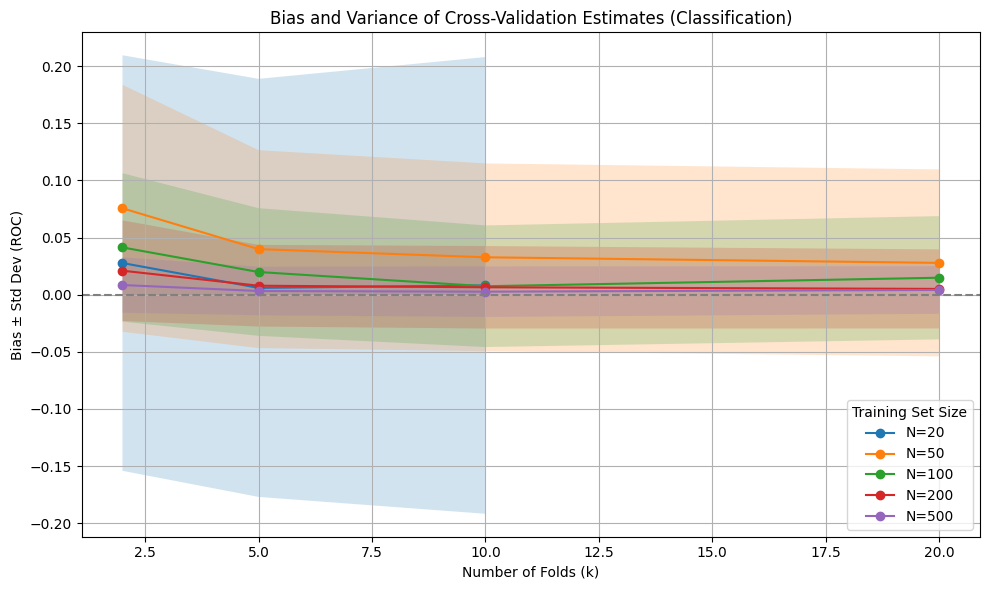

In [12]:
# visualize the results
fig, ax = plt.subplots(figsize=(10, 6))
for i, n_train in enumerate(sample_sizes):
    valid = mean_bias_cls[i, :] != 0  # only include valid fold counts
    x_vals = np.array(k_folds)[valid]
    y_vals = mean_bias_cls[i, valid]
    std_vals = std_bias_cls[i, valid]
    
    ax.plot(x_vals, y_vals, label=f'N={n_train}', marker='o')
    ax.fill_between(x_vals, y_vals - std_vals, y_vals + std_vals, alpha=0.2)

ax.axhline(0, linestyle='--', color='gray')
ax.set_xlabel('Number of Folds (k)')
ax.set_ylabel('Bias ± Std Dev (ROC)')
ax.set_title('Bias and Variance of Cross-Validation Estimates (Classification)')
ax.legend(title='Training Set Size')
plt.grid(True)
plt.tight_layout()
plt.show()

## PROBLEM 2: Nested vs Regular CV

We will investigate the bias associated with combining model selection and generalization estimation in the same cross validation. We will repeat a single configuration many times and observe the difference. 

We will use L2-penalized logistic regression, which has a hyperparameter C. 

Insert cells as necessary to develop your solutions. 

In [13]:
# DO NOT EDIT
def generate_nested_cv_data(n_train):
    X, y = make_classification(n_samples=n_train+TEST_SAMPLES
                               , n_features=100 # a lot of features to make overfitting likely
                               # affecting distribution of data, make it hard 
                               # so we can visualize differences
                               , n_informative=2 
                               , n_redundant=20 
                               , n_repeated=20
                               , flip_y=0.2 
                               , class_sep=0.5)
                
    X_train = X[:n_train]
    y_train = y[:n_train]
    X_test = X[n_train:]
    y_test = y[n_train:]
    return X_train, y_train, X_test, y_test

### STEP 1: Regular CV
* Use a single k-fold cross-validation loop to both:
    - Select the best `C`
    - Estimate performance (AUC)

In [14]:
def regular_cv(X, y, param_grid, k=3):
    # COMPLETE THIS FUNCTION:
    # Given X and y, use cross validation to 
    # optimize a logistic regression model by  
    # selecting the best value of C in param_grid
    # and return the corresponding roc auc score.
    
    # C is a parameter in the logistic regression model
    best_auc = -1
    best_C = None

    for C in param_grid['C']:  # unpack C values from the dict
        model = LogisticRegression(C=C, solver='liblinear')
        preds = cross_val_predict(model, X, y, cv=k, method='predict_proba')[:,1]
        auc = roc_auc_score(y, preds)  # use probs for class 1

        if auc > best_auc:
            best_auc = auc
            best_C = C

    return auc, best_C

### STEP 2: Nested CV
Implement nested CV below to estimate the best parameter `C` in an inner CV loop, and estimate performance in an outer CV loop

In [ ]:
def nested_cv(X, y, param_grid, outer_k=3, inner_k=3):
    # COMPLETE THIS FUNCTION
    # given X and y, use NESTED cross validation 
    
    # C is a parameter in the logistic regression model
    # model = LogisticRegression(C, solver='liblinear')

    outer = KFold(n_splits=outer_k, shuffle=True, random_state=42)
    outer_aucs = []
    best_Cs = []

    for train_idx, val_idx in outer.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
                
        _, best_inner_C = regular_cv(X_train, y_train, param_grid, k=inner_k)

        best_Cs.append(best_inner_C)

        final_model = LogisticRegression(C=best_inner_C, solver='liblinear')
        final_model.fit(X_train, y_train)
        val_preds = final_model.predict_proba(X_val)[:,1]
        val_auc = roc_auc_score(y_val, val_preds)

        outer_aucs.append(val_auc)

    auc = np.mean(outer_aucs)
    
    return auc, best_inner_C # HINT: the average auc in the outer loop

Then we can run and visualize the differences. 

In [16]:
# DO NOT EDIT
def nested_cv_comparison(n_trials, n_train, k, param_grid):
    
    aucs_naive, aucs_nested = [], [] # , aucs_test = [], [], []

    for i in tqdm(range(n_trials)):
        X_train, y_train, X_test, y_test = generate_nested_cv_data(n_train) 
        naive_auc, naive_C = regular_cv(X_train, y_train, param_grid, k)
        nested_auc, nested_C = nested_cv(X_train, y_train, param_grid, outer_k=k, inner_k=k)
        # shortcut to getting the actual C
        # oracle_C = LogisticRegressionCV().fit(X_train, y_train).C_[0]
        
        # true_model = LogisticRegression(C=oracle_C, solver='liblinear')
        # true_model.fit(X_train, y_train)
        # true_model_preds = true_model.predict_proba(X_test)[:, 1]
        # true_auc = roc_auc_score(y_test, true_model_preds)

        aucs_naive.append(naive_auc)
        aucs_nested.append(nested_auc)
        # aucs_test.append(true_auc)

    return aucs_naive, aucs_nested# , aucs_test


In [17]:
# DO NOT EDIT
sample_sizes = [50, 100, 200]
TEST_SAMPLES = 5000
n_trials = 100
# logistic regression parameters to optimize
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

values = {'naive': [], 'nested': []} # , 'true': []}
for n_train in sample_sizes:
    aucs_naive, aucs_nested = nested_cv_comparison(
    # , aucs_test = nested_cv_comparison(
        n_trials, n_train, k=3, param_grid=param_grid)
    values['naive'].append((n_train, np.nanmean(aucs_naive), np.nanstd(aucs_naive)))
    values['nested'].append((n_train, np.nanmean(aucs_nested), np.nanstd(aucs_nested)))
    # values['true'].append((n_train, np.nanmean(aucs_test), 0))


100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


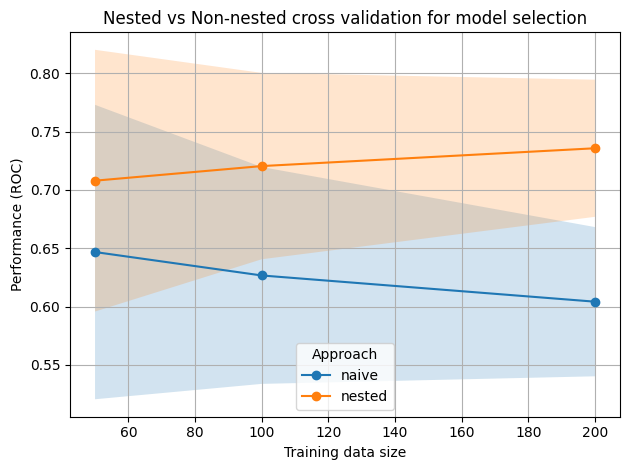

In [18]:
# DO NOT EDIT
fig, ax = plt.subplots()
for key in ['naive', 'nested']: # , 'true']:
    data = np.array(values[key])
    x_vals = data[:, 0]
    y_vals = data[:, 1]
    std_vals = data[:, 2]
    
    ax.plot(x_vals, y_vals, label=key, marker='o')
    ax.fill_between(x_vals, y_vals - std_vals, y_vals + std_vals, alpha=0.2)

# ax.axhline(0, linestyle='--', color='gray')
ax.set_xlabel('Training data size')
ax.set_ylabel('Performance (ROC)')
ax.set_title('Nested vs Non-nested cross validation for model selection')
ax.legend(title='Approach')
plt.grid(True)
plt.tight_layout()
plt.show()
